In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import nbodykit.lab as nb
from tqdm.notebook import tqdm
from scipy.stats import binned_statistic

In [2]:
def readpk(filename):
    d = nb.ConvolvedFFTPower.load(filename)
    return (d.poles['k'], d.poles['power_0'].real- d.attrs['shotnoise']) # 

In [3]:
cap = 'NGC'
nside = '512'

path = '/home/mehdi/data/eboss/mocks/1.0/measurements/spectra/'
pkname = lambda p, c, m, n, i, ix:f'{p}spectra_{c}_{m}_mainhighz_{n}_v7_{i}_{ix:04d}_main.json'

In [4]:
pks = []

for ix in tqdm(range(1, 1000+1)):
    k0, p0 = readpk(pkname(path, cap, 'knownsystot', nside, '0', ix))    
    k1, p1 = readpk(pkname(path, cap, 'knownsystot', nside, '1', ix))    
    k2, p2 = readpk(pkname(path, cap, 'known', nside, '1', ix))        
    
    pks.append([p0, p1, p2])
    
pks = np.array(pks)*1.0e-4
pks.shape

(1000, 3, 128)

In [5]:
pks.shape

(1000, 3, 128)

In [11]:
from scipy.stats import pearsonr

yx = 0
def scatter(ax, x, y, **kw):
    global yx
    pcc = pearsonr(x, y)    
    bc,_,bid = binned_statistic(x, x, statistic='mean')      
    
    rmead = []
    rmin = []
    rmax = []
    for bid_id  in range(bc.size):
        good = bid == bid_id+1
        if good.sum() == 0:
            rmin.append(np.nan)
            rmax.append(np.nan) 
            rmead.append(np.nan)
            continue
        rmin_, rmead_, rmax_ = np.percentile(y[good], [15.9, 50, 84.1]) # 1 sig.
        rmead.append(rmead_)
        rmin.append(rmin_)        
        rmax.append(rmax_)
        
    rmin = np.array(rmin)
    rmax = np.array(rmax)
    rmead = np.array(rmead)
    
    ax.scatter(x, y, 5, **kw)
    ax.errorbar(bc, rmead, yerr=[rmead-rmin, rmax-rmead], 
                color=kw['c'], mfc='w', marker='o', capsize=3)
    #ax.fill_between(bc, rmean-abs(r-rmin), r+abs(rmax-r), color=kw['c'], alpha=0.1)
    
    ax.text(0.7, 0.1-yx*0.05, f'PCC={pcc[0]:.3f}', color=kw['c'], transform=ax.transAxes)
    
    yx += 1 

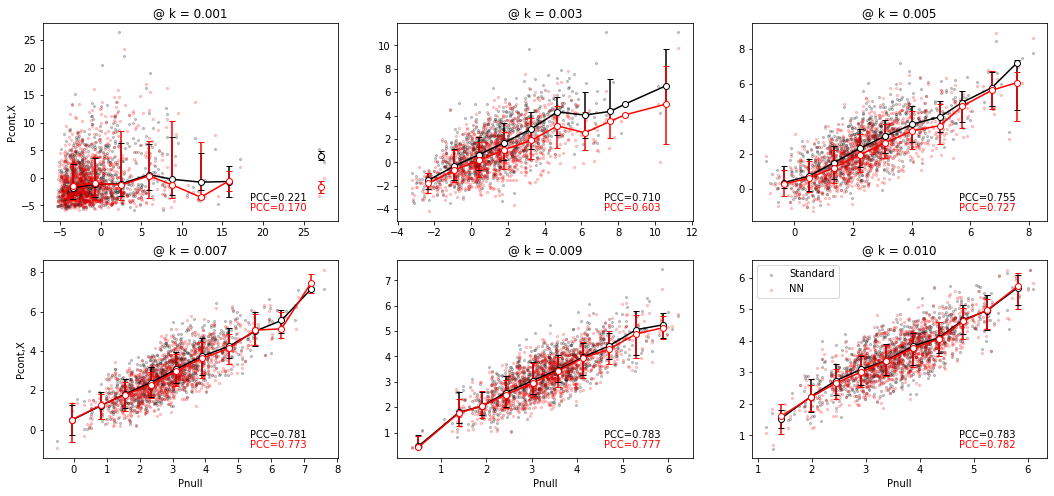

In [12]:
f, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 8))
ax = ax.flatten()

yx = 0
for i, ix in enumerate([0, 1, 2, 3, 4, 5]):
    scatter(ax[i], pks[:, 0, ix], pks[:, 1, ix], c='k', alpha=0.2, label='Standard')
    scatter(ax[i], pks[:, 0, ix], pks[:, 2, ix], c='r', alpha=0.2, label='NN')
    ax[i].set_title(f'@ k = {k0[ix]:.3f}')
    yx = 0
    
ax[-1].legend()

for axi in ax[-3:]:
    axi.set_xlabel('Pnull')
    
for i in [0, 3]:
    ax[i].set_ylabel('Pcont,X')    

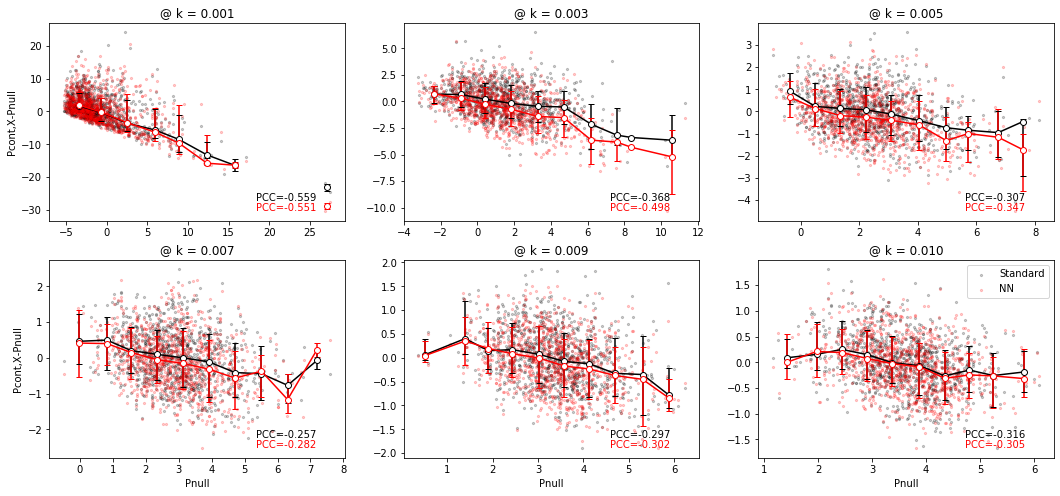

In [13]:
f, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 8))
ax = ax.flatten()

yx = 0
for i, ix in enumerate([0, 1, 2, 3, 4, 5]):
    scatter(ax[i], pks[:, 0, ix], pks[:, 1, ix]-pks[:, 0, ix], c='k', alpha=0.2, label='Standard')
    scatter(ax[i], pks[:, 0, ix], pks[:, 2, ix]-pks[:, 0, ix], c='r', alpha=0.2, label='NN')
    ax[i].set_title(f'@ k = {k0[ix]:.3f}')
    yx = 0
    
ax[-1].legend()

for axi in ax[-3:]:
    axi.set_xlabel('Pnull')
    
for i in [0, 3]:
    ax[i].set_ylabel('Pcont,X-Pnull')

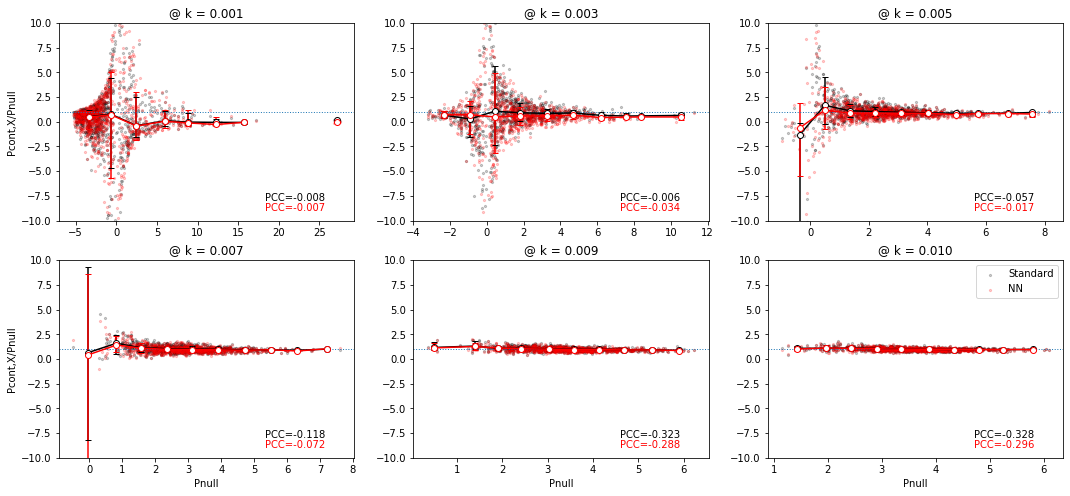

In [16]:
f, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 8))
ax = ax.flatten()

yx = 0
for i, ix in enumerate([0, 1, 2, 3, 4, 5]):
    scatter(ax[i], pks[:, 0, ix], pks[:, 1, ix]/pks[:, 0, ix], c='k', alpha=0.2, label='Standard')
    scatter(ax[i], pks[:, 0, ix], pks[:, 2, ix]/pks[:, 0, ix], c='r', alpha=0.2, label='NN')
    ax[i].set_title(f'@ k = {k0[ix]:.3f}')
    ax[i].axhline(1, ls=':', lw=1)
    ax[i].set_ylim(-10, 10)
    yx = 0
    
ax[-1].legend()

for axi in ax[-3:]:
    axi.set_xlabel('Pnull')
    
for i in [0, 3]:
    ax[i].set_ylabel('Pcont,X/Pnull')

In [36]:
dp = {'standard':[], 'nnknown':[]}

for ix in tqdm(range(1, 1000+1)):
    k0, p0 = readpk(pkname(path, cap, 'knownsystot', nside, '0', ix))    
    k1, p1 = readpk(pkname(path, cap, 'knownsystot', nside, '1', ix))    
    k2, p2 = readpk(pkname(path, cap, 'known', nside, '1', ix))        
    
    dp['standard'].append([p0, p1-p0])
    dp['nnknown'].append([p0, p2-p0])
    
dpc = {}
for n,v in dp.items():
    dpc[n] = np.array(v)*1.0e-4  

In [6]:
plt.rc('font', size=18)

Text(0.5, 1.0, 'w/ shotnoise subtraction')

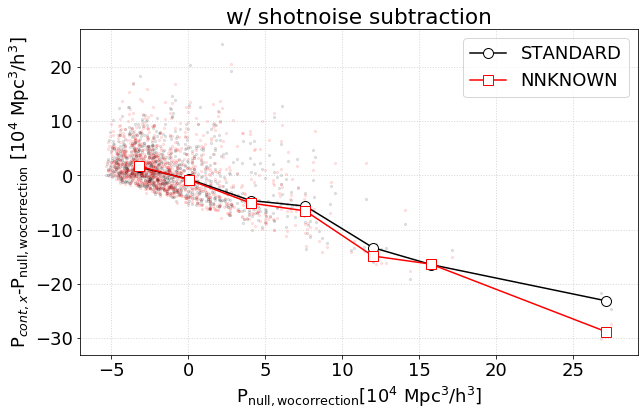

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))

bins = np.linspace(-5.5, 30., num=10)

colors = ['k', 'red']
markers = ['o', 's']

for i, (n, v) in enumerate(dpc.items()):
    r,_,_ = binned_statistic(v[:, 0], v[:, 1], 
                             statistic='median', bins=bins)  
    bc,_,_ = binned_statistic(v[:, 0], v[:, 0], 
                             statistic='mean', bins=bins)  
    #std,_,_ = binned_statistic(v[:, 0], v[:, 1], 
    #                         statistic='std', bins=bins)  
    #nm,_,_ = binned_statistic(v[:, 0], np.ones(v.shape[0]), 
    #                         statistic='count', bins=bins)      
    
    ax.scatter(v[:, 0], v[:,1], 5, color=colors[i], alpha=0.1)    
    msk = np.isfinite(r)
    ax.plot(bc[msk], r[msk],
            marker=markers[i], color=colors[i], mfc='w', 
            label=n.upper(), ms=10)
    
ax.grid(lw=1, alpha=0.5, ls=':')  
ax.set(xlabel=r'P$_{{\rm null, wo correction}}$[10$^{4}$ Mpc$^{3}$/h$^{3}$]', 
       ylabel=r'P$_{cont, x}$-P$_{{\rm null, wo correction}}$ [10$^{4}$ Mpc$^{3}$/h$^{3}$]')
ax.legend()
ax.set_title('w/ shotnoise subtraction')

In [37]:
np.percentile(dpc['nnknown'][:, 0], [0, 100])

array([-5.30924267, 27.48701987])

Text(0.5, 1.0, 'w shotnoise subtraction at k=0.0014')

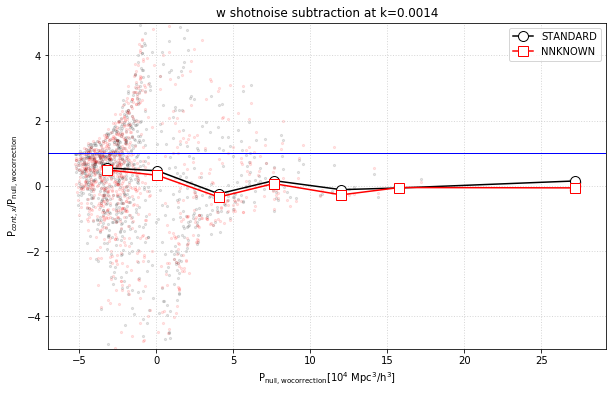

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))

bins = np.linspace(-5.5, 30., num=10)
#bins = np.linspace(-1, 1.)
# bins = np.linspace(-4, 12.)

colors = ['k', 'red']
markers = ['o', 's']

for i, (n, v) in enumerate(dpc.items()):
    r,_,_ = binned_statistic(v[:, 0], (v[:, 1]+v[:, 0])/v[:, 0], 
                             statistic='median', bins=bins)  
#     r1,_,_ = binned_statistic(v[:, 0], (v[:, 1]+v[:, 0])/v[:, 0], 
#                              statistic='mean', bins=bins)      
    bc,_,_ = binned_statistic(v[:, 0], v[:, 0], 
                             statistic='mean', bins=bins)  
    #std,_,_ = binned_statistic(v[:, 0], v[:, 1], 
    #                         statistic='std', bins=bins)  
    #nm,_,_ = binned_statistic(v[:, 0], np.ones(v.shape[0]), 
    #                         statistic='count', bins=bins)      
    
    ax.scatter(v[:, 0], v[:, 1]/v[:, 0]+1.0, 5, color=colors[i], alpha=0.1)    
    msk = np.isfinite(r)
    ax.plot(bc[msk], r[msk],
            marker=markers[i], color=colors[i], mfc='w', 
            label=n.upper(), ms=10)
    #ax.plot(bc[msk], r1[msk],
    #        marker=markers[i], color=colors[i], mfc='w', ms=10, ls='--')

ax.axhline(1., ls='-', lw=1, color='b')    
    
ax.grid(lw=1, alpha=0.5, ls=':')  
ax.set(xlabel=r'P$_{{\rm null, wo correction}}$[10$^{4}$ Mpc$^{3}$/h$^{3}$]', 
       ylabel=r'P$_{cont, x}$/P$_{{\rm null, wo correction}}$') # [10$^{4}$ Mpc$^{3}$/h$^{3}$]
ax.set(ylim=(-5., 5.))

ax.legend()
ax.set_title(f'w shotnoise subtraction at k={k0:.4f}')